I have used the following methods.

* <b>Dice coefficient</b> and <b>Jaccard index</b> implementation,
* The project took place using <b>Google TPU</b>,
* <b>Custom layers</b> for encoding and decoding,
* <b>Custom callback</b> class  that used predicting a sample from the train dataset during training

## Results for 30 epochs
* Test Dice Coefficient : <b>0.9485</b>
* Test Jaccard Index : <b>0.9027</b>

## Prediction samples

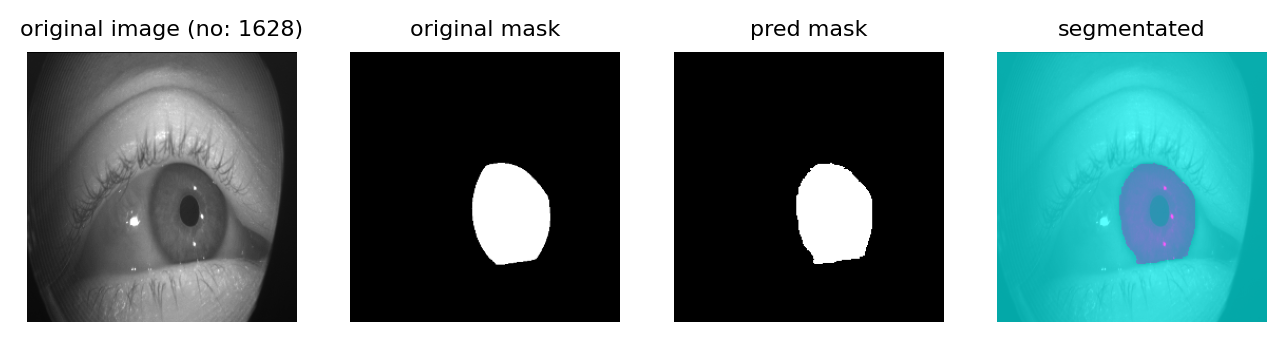
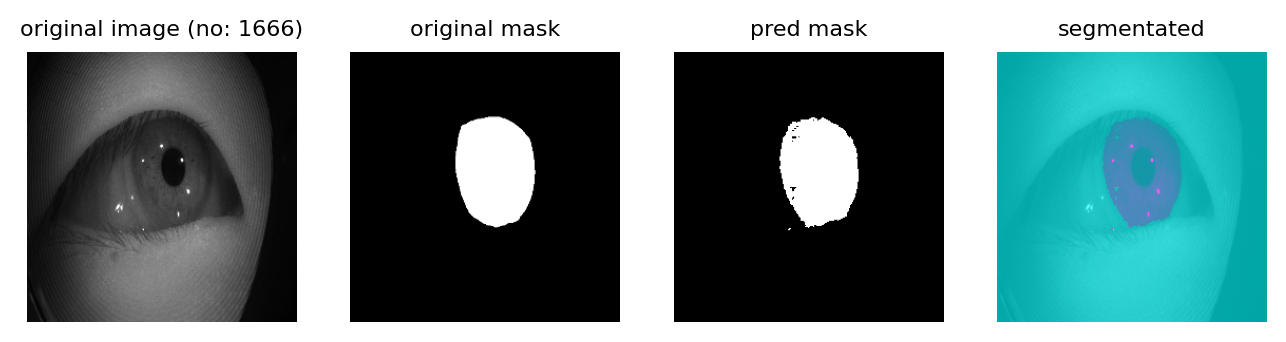


## References
1. Ronneberger, O., Fischer, P., & Brox, T. (2015). U-Net: Convolutional Networks for Biomedical Image Segmentation (Version 1). arXiv. https://doi.org/10.48550/ARXIV.1505.04597
2. https://www.aao.org/eye-health/anatomy/parts-of-eye
3. https://en.wikipedia.org/wiki/Sørensen–Dice_coefficient

In [1]:
# Importing dependencies

import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2

import tensorflow as tf
from tensorflow import keras
from keras import backend as K
from tensorflow.keras.layers import Input, Conv2D,UpSampling2D, Dropout, MaxPooling2D, concatenate, Lambda, BatchNormalization, Activation, Layer
from tensorflow.keras.layers import Add, Multiply, Input, MaxPool2D, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import Callback


BATCH_SIZE = 64


D0909 17:16:18.762703780      14 config.cc:119]                        gRPC EXPERIMENT tcp_frame_size_tuning               OFF (default:OFF)
D0909 17:16:18.762734288      14 config.cc:119]                        gRPC EXPERIMENT tcp_rcv_lowat                       OFF (default:OFF)
D0909 17:16:18.762737936      14 config.cc:119]                        gRPC EXPERIMENT peer_state_based_framing            OFF (default:OFF)
D0909 17:16:18.762740723      14 config.cc:119]                        gRPC EXPERIMENT flow_control_fixes                  ON  (default:ON)
D0909 17:16:18.762743169      14 config.cc:119]                        gRPC EXPERIMENT memory_pressure_controller          OFF (default:OFF)
D0909 17:16:18.762745831      14 config.cc:119]                        gRPC EXPERIMENT unconstrained_max_quota_buffer_size OFF (default:OFF)
D0909 17:16:18.762748363      14 config.cc:119]                        gRPC EXPERIMENT new_hpack_huffman_decoder           ON  (default:ON)
D0909 17:16:18.

In [2]:
# Connecting TPU and creating strategy and the model

tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
strategy = tf.distribute.TPUStrategy(tpu)

INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.
INFO:tensorflow:Initializing the TPU system: local
INFO:tensorflow:Finished initializing TPU system.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU

# <span style="color:#e74c3c;"> Preprocessing </span>


In [3]:
# Creating new folders for preprocessing masks

os.mkdir(os.path.join('/kaggle/working/', 'train_masks'))
os.mkdir(os.path.join('/kaggle/working/', 'validation_masks'))
os.mkdir(os.path.join('/kaggle/working/', 'test_masks'))

In [4]:
def create_new_masks(main_path, target_path):
    for i in os.listdir(main_path):
        img = cv2.imread(os.path.join(main_path, i ))[:,::,2]
        f, bw_img = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY)
        cv2.imwrite(os.path.join(target_path,i), bw_img)

In [5]:
create_new_masks('/kaggle/input/openeds-dataset/openEDS/openEDS/train/masks','/kaggle/working/train_masks' )
create_new_masks('/kaggle/input/openeds-dataset/openEDS/openEDS/validation/masks','/kaggle/working/validation_masks' )
create_new_masks('/kaggle/input/openeds-dataset/openEDS/openEDS/test/masks','/kaggle/working/test_masks' )

# <span style="color:#e74c3c;"> Creating </span> Datasets


In [6]:
# Creating main dataframe contains image paths and their classes.

def create_images_list(path):
    data = []
    images = sorted(os.listdir(path))
    for i in images:
        data.append(os.path.join(path, i))
        
    return data



train_images = create_images_list('/kaggle/input/openeds-dataset/openEDS/openEDS/train/images')
train_labels = create_images_list('/kaggle/working/train_masks')

validation_images = create_images_list('/kaggle/input/openeds-dataset/openEDS/openEDS/validation/images')
validation_labels = create_images_list('/kaggle/working/validation_masks')

test_images = create_images_list('/kaggle/input/openeds-dataset/openEDS/openEDS/test/images')
test_labels = create_images_list('/kaggle/working/test_masks')


train_df = pd.DataFrame( {"image" : train_images, "label":train_labels } )
validation_df = pd.DataFrame( {"image" : validation_images, "label":validation_labels } )
test_df = pd.DataFrame( {"image" : test_images, "label":test_labels } )

In [7]:
print("train images: ", train_df.shape[0])
print("val images: ", validation_df.shape[0])
print("test images: ", test_df.shape[0])

train images:  27431
val images:  2744
test images:  2744


In [8]:
def img_preprocessing(image, label):
    img = tf.io.read_file(image)
    img = tf.io.decode_png(img, channels = 3)
    img = tf.image.rgb_to_grayscale(img)
    img = tf.image.resize(img, size = (256, 256))
    img = tf.cast(img, tf.float32)/255.0
    
    mask = tf.io.read_file(label)
    mask = tf.io.decode_png(mask, channels = 1)
    mask = tf.image.resize(mask, size = (256, 256 ))
    mask = tf.cast(mask, tf.float32)/255.0
    
    return img, mask


def img_augmentation(image, label):
    
    img = tf.image.random_brightness(image, 0.1)
    img = tf.image.random_contrast(img, 0.1, 0.3)
    
    return img, label


In [9]:
# Creating dataset loaders

train_loader = tf.data.Dataset.from_tensor_slices((train_df['image'], train_df['label'] ))
train_dataset = (train_loader
                 .map(img_preprocessing)
                 .map(img_augmentation)
                 .batch(BATCH_SIZE)
                 .shuffle(train_df.shape[0])
                 .prefetch(BATCH_SIZE))

val_loader = tf.data.Dataset.from_tensor_slices((validation_df['image'], validation_df['label'] ))
val_dataset = (val_loader
               .map(img_preprocessing)
               .batch(BATCH_SIZE)
               .prefetch(BATCH_SIZE))

test_loader = tf.data.Dataset.from_tensor_slices((test_df['image'], test_df['label'] ))
test_dataset = (test_loader
                .map(img_preprocessing)
                .batch(BATCH_SIZE)
                .prefetch(BATCH_SIZE))

# <span style="color:#e74c3c;"> U-net </span> Model


In [10]:
# Encoding block for U-net architecture

class EncoderBlock(Layer):
    
    def __init__(self, filters, kernel_size, rate, pooling = True, **kwargs):
        super(EncoderBlock, self).__init__(**kwargs)
    
        self.filters = filters
        self.kernel_size = kernel_size
        self.rate = rate
        self.pooling = pooling

        self.conv1 = Conv2D(filters, kernel_size, strides = 1, padding = 'same', activation = 'relu', kernel_initializer = 'lecun_normal')
        self.conv2 = Conv2D(filters, kernel_size, strides = 1, padding = 'same', activation = 'relu', kernel_initializer = 'lecun_normal')
        self.drop = Dropout(rate)
        self.pool = MaxPooling2D()


    def call(self, inputs):
        X = self.conv1(inputs)
        X = self.drop(X)
        X = self.conv2(X)
        if self.pooling:
            P = self.pool(X)
            return P, X
        else:
            return X


    def get_config(self):
        base_config = super().get_config()
        
        return {
          **base_config,
          "filters" : self.filters,
          "kernel_size": self.kernel_size,
          "rate" : self.rate,
          "pooling" : self.pooling
      }

In [11]:
# Decoding block for U-net architecture

class DecoderBlock(Layer):
    
    def __init__(self, filters, kernel_size, rate, **kwargs ):
        super(DecoderBlock, self).__init__(**kwargs)

        self.filters = filters
        self.kernel_size = kernel_size
        self.rate = rate

        self.up = UpSampling2D()
        self.net = EncoderBlock(filters, kernel_size, rate, pooling = False)


    def call(self, inputs):
        inputs, skip_inputs = inputs
        X = self.up(inputs)
        C_ = concatenate([X, skip_inputs ])
        X = self.net(C_)
        return X


    def get_config(self):
        base_config = super().get_config()
        return {
        **base_config,
        "filters" : self.filters,
        "kernel_size": self.kernel_size,
        "rate" : self.rate
        }

In [12]:
# A function that creating one sample from the validation set

def sample_validation_image_and_mask():
    samples = list(val_dataset.take(-1))
    idxs = np.random.permutation(validation_df.shape[0])[0]
    batch_idx = idxs // BATCH_SIZE
    image_idx = idxs-batch_idx * BATCH_SIZE
    idx = idxs

    image = samples[batch_idx][0][image_idx] 
    mask = samples[batch_idx][1][image_idx]
    

    fig, axs = plt.subplots(1,3, figsize = (6, 2) ,dpi = 150)

    axs[0].imshow(image , cmap = 'gray')
    axs[0].axis('off')
    axs[0].set_title('original image (no: ' + str(idxs) + ")", fontsize = 8)

    axs[1].imshow(mask, cmap = 'gray')
    axs[1].axis('off')
    axs[1].set_title('original mask', fontsize = 8)

    axs[2].imshow( image * mask, cmap = 'gray')
    axs[2].axis('off')
    axs[2].set_title('predicted mask', fontsize = 8)

    plt.tight_layout()
    plt.show()
    

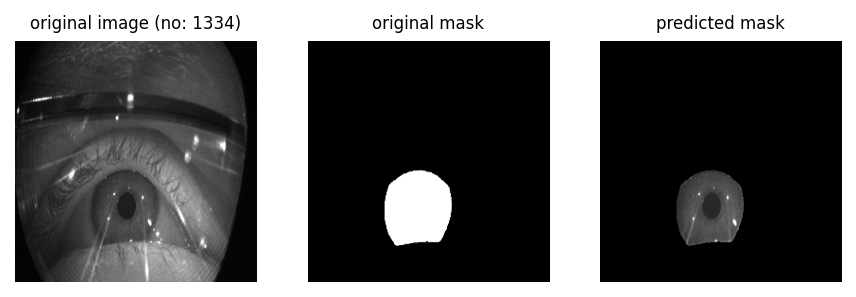

In [13]:
sample_validation_image_and_mask()

In [14]:
# Custom callback for predicting one sample from validation dataset during training

class PredictDuringTraining(Callback):
    def on_epoch_end(self, epochs, logs=None):
        
        samples = list(val_dataset.take(-1))
     
        idxs = np.random.permutation(validation_df.shape[0])[0]
        batch_idx = idxs // BATCH_SIZE
        image_idx = idxs-batch_idx * BATCH_SIZE
        idx = idxs

        image = samples[batch_idx][0][image_idx] 
        mask = samples[batch_idx][1][image_idx]
        
        pred_mask = self.model.predict(image[np.newaxis,...], verbose = 0)
        pred_ = np.squeeze(pred_mask)
        threshold  = 0.9
        bitmap_pred = (pred_ > threshold).astype(np.uint8)

        fig, axs = plt.subplots(1,3, figsize = (5,2) ,dpi = 120)

        axs[0].imshow(image , cmap = 'gray')
        axs[0].axis('off')
        axs[0].set_title('original image')

        axs[1].imshow(mask, cmap = 'gray')
        axs[1].axis('off')
        axs[1].set_title('original mask')

        axs[2].imshow( bitmap_pred, cmap = 'gray')
        axs[2].axis('off')
        axs[2].set_title('segmented iris')

        plt.tight_layout()
        plt.show()

In [15]:
# Creating Dice and Jaccard metrics

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2 * intersection+1) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1)


def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)


def jaccard(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    jac = intersection  / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1e-4 )
    return jac

# <span style="color:#e74c3c;"> Training </span> 


In [16]:
with strategy.scope():
    input_layer = Input(shape = (256, 256, 1))

    p1, c1 = EncoderBlock(32, 2, 0.1, name = 'Encoder_1')(input_layer)
    p2, c2 = EncoderBlock(64, 2, 0.1, name = 'Encoder_2')(p1)
    p3, c3 = EncoderBlock(128, 2, 0.2, name = 'Encoder_3')(p2)
    p4, c4 = EncoderBlock(256, 2, 0.2, name = 'Encoder_4')(p3)

    encoding = EncoderBlock(512 , 2, 0.3, pooling = False ,name = 'Encoding')(p4)

    d1 = DecoderBlock(256, 2, 0.2 ,name = 'Decoder_1' )([encoding, c4])
    d2 = DecoderBlock(128 ,2, 0.2 ,name = 'Decoder_2' )([d1, c3])
    d3 = DecoderBlock(64 ,2, 0.1 ,name = 'Decoder_3' )([d2, c2])
    d4 = DecoderBlock(32 ,2, 0.1 ,name = 'Decoder_4' )([d3, c1])

    output_layer = Conv2D(1, kernel_size = 1 ,activation ='sigmoid', padding = 'same')(d4)

    model = Model(inputs = input_layer , outputs = output_layer)
    model.summary()

    model.compile(optimizer  =  tf.keras.optimizers.Adam() , loss = 'binary_crossentropy', metrics = [dice_coef, jaccard ]) 
    my_callbacks = [PredictDuringTraining()]

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 Encoder_1 (EncoderBlock)       ((None, 128, 128, 3  4288        ['input_1[0][0]']                
                                2),                                                               
                                 (None, 256, 256, 3                                               
                                2))                                                               
                                                                                              

Epoch 1/40


2023-09-09 17:21:36.826601: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-09-09 17:21:37.036518: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


429/429 [==============================] - ETA: 0s - loss: 0.2481 - dice_coef: 0.1205 - jaccard: 0.0642

2023-09-09 17:22:53.919909: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-09-09 17:22:54.046834: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-09-09 17:23:13.823157: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-09-09 17:23:13.911612: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


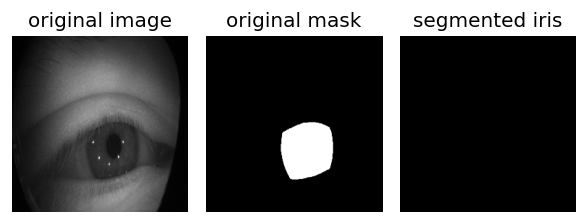

429/429 [==============================] - 108s 165ms/step - loss: 0.2481 - dice_coef: 0.1205 - jaccard: 0.0642 - val_loss: 0.2265 - val_dice_coef: 0.1384 - val_jaccard: 0.0744
Epoch 2/40
429/429 [==============================] - ETA: 0s - loss: 0.2101 - dice_coef: 0.1999 - jaccard: 0.1131

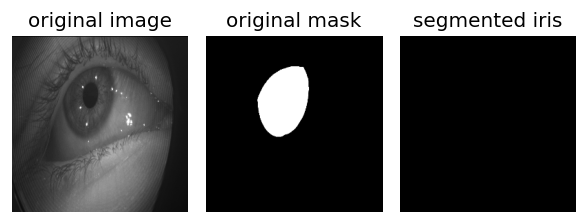

429/429 [==============================] - 61s 93ms/step - loss: 0.2101 - dice_coef: 0.1999 - jaccard: 0.1131 - val_loss: 0.1704 - val_dice_coef: 0.3436 - val_jaccard: 0.2094
Epoch 3/40
429/429 [==============================] - ETA: 0s - loss: 0.1576 - dice_coef: 0.3716 - jaccard: 0.2317

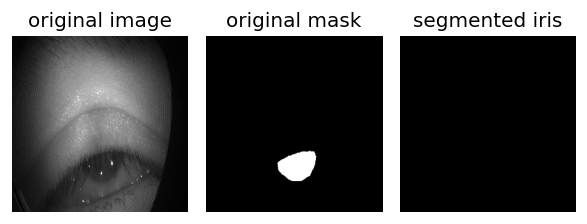

429/429 [==============================] - 59s 92ms/step - loss: 0.1576 - dice_coef: 0.3716 - jaccard: 0.2317 - val_loss: 0.1389 - val_dice_coef: 0.4914 - val_jaccard: 0.3293
Epoch 4/40
429/429 [==============================] - ETA: 0s - loss: 0.1287 - dice_coef: 0.4850 - jaccard: 0.3250

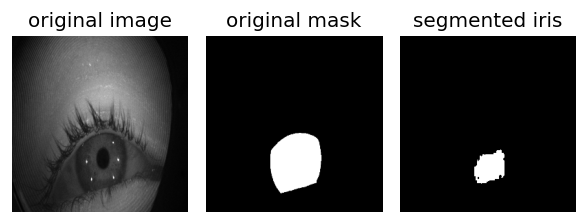

429/429 [==============================] - 54s 92ms/step - loss: 0.1287 - dice_coef: 0.4850 - jaccard: 0.3250 - val_loss: 0.1417 - val_dice_coef: 0.5947 - val_jaccard: 0.4297
Epoch 5/40
429/429 [==============================] - ETA: 0s - loss: 0.1036 - dice_coef: 0.5901 - jaccard: 0.4239

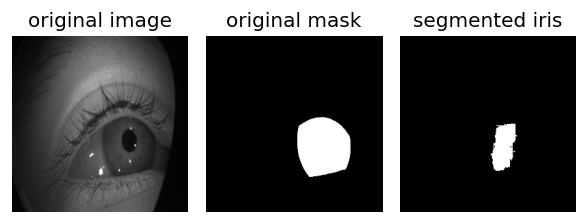

429/429 [==============================] - 59s 92ms/step - loss: 0.1036 - dice_coef: 0.5901 - jaccard: 0.4239 - val_loss: 0.1123 - val_dice_coef: 0.6646 - val_jaccard: 0.5025
Epoch 6/40
429/429 [==============================] - ETA: 0s - loss: 0.0880 - dice_coef: 0.6515 - jaccard: 0.4889

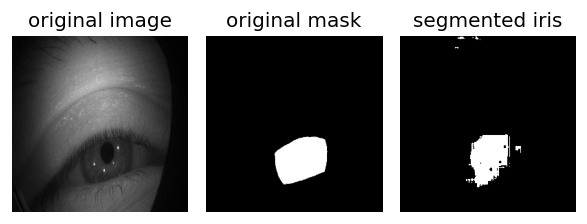

429/429 [==============================] - 53s 92ms/step - loss: 0.0880 - dice_coef: 0.6515 - jaccard: 0.4889 - val_loss: 0.1658 - val_dice_coef: 0.6615 - val_jaccard: 0.4995
Epoch 7/40
429/429 [==============================] - ETA: 0s - loss: 0.0725 - dice_coef: 0.7160 - jaccard: 0.5622

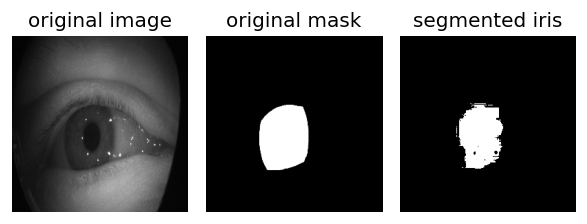

429/429 [==============================] - 55s 94ms/step - loss: 0.0725 - dice_coef: 0.7160 - jaccard: 0.5622 - val_loss: 0.1141 - val_dice_coef: 0.7000 - val_jaccard: 0.5435
Epoch 8/40
429/429 [==============================] - ETA: 0s - loss: 0.0609 - dice_coef: 0.7611 - jaccard: 0.6182

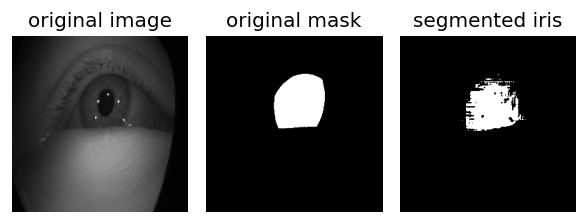

429/429 [==============================] - 59s 92ms/step - loss: 0.0609 - dice_coef: 0.7611 - jaccard: 0.6182 - val_loss: 0.1065 - val_dice_coef: 0.7448 - val_jaccard: 0.5973
Epoch 9/40
429/429 [==============================] - ETA: 0s - loss: 0.0494 - dice_coef: 0.8070 - jaccard: 0.6795

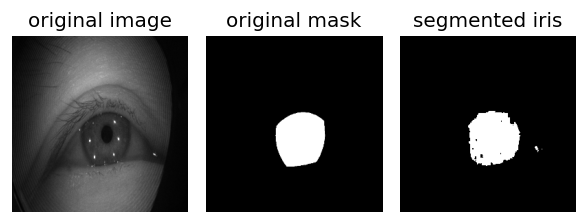

429/429 [==============================] - 53s 92ms/step - loss: 0.0494 - dice_coef: 0.8070 - jaccard: 0.6795 - val_loss: 0.0869 - val_dice_coef: 0.7671 - val_jaccard: 0.6263
Epoch 10/40
429/429 [==============================] - ETA: 0s - loss: 0.0411 - dice_coef: 0.8405 - jaccard: 0.7275

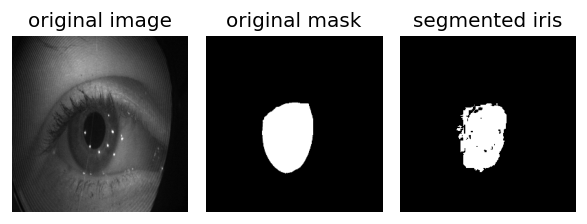

429/429 [==============================] - 53s 92ms/step - loss: 0.0411 - dice_coef: 0.8405 - jaccard: 0.7275 - val_loss: 0.0709 - val_dice_coef: 0.8049 - val_jaccard: 0.6773
Epoch 11/40
429/429 [==============================] - ETA: 0s - loss: 0.0320 - dice_coef: 0.8763 - jaccard: 0.7817

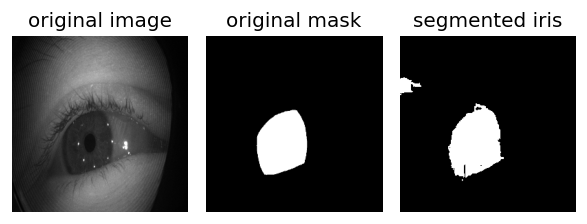

429/429 [==============================] - 55s 93ms/step - loss: 0.0320 - dice_coef: 0.8763 - jaccard: 0.7817 - val_loss: 0.0685 - val_dice_coef: 0.8068 - val_jaccard: 0.6802
Epoch 12/40
429/429 [==============================] - ETA: 0s - loss: 0.0270 - dice_coef: 0.8953 - jaccard: 0.8121

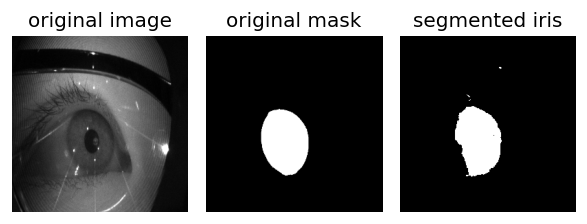

429/429 [==============================] - 57s 93ms/step - loss: 0.0270 - dice_coef: 0.8953 - jaccard: 0.8121 - val_loss: 0.0996 - val_dice_coef: 0.7793 - val_jaccard: 0.6427
Epoch 13/40
429/429 [==============================] - ETA: 0s - loss: 0.0232 - dice_coef: 0.9100 - jaccard: 0.8363

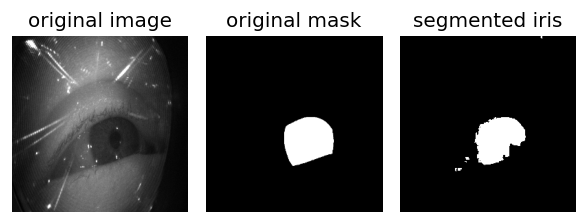

429/429 [==============================] - 59s 92ms/step - loss: 0.0232 - dice_coef: 0.9100 - jaccard: 0.8363 - val_loss: 0.0495 - val_dice_coef: 0.8728 - val_jaccard: 0.7772
Epoch 14/40
429/429 [==============================] - ETA: 0s - loss: 0.0203 - dice_coef: 0.9216 - jaccard: 0.8557

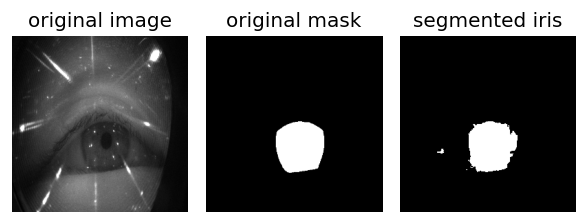

429/429 [==============================] - 54s 92ms/step - loss: 0.0203 - dice_coef: 0.9216 - jaccard: 0.8557 - val_loss: 0.0871 - val_dice_coef: 0.8392 - val_jaccard: 0.7262
Epoch 15/40
429/429 [==============================] - ETA: 0s - loss: 0.0182 - dice_coef: 0.9295 - jaccard: 0.8691

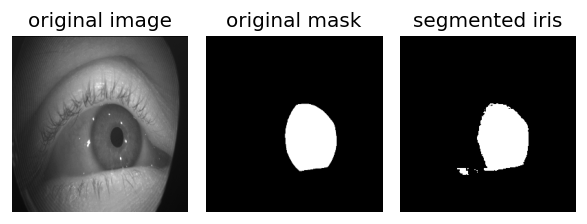

429/429 [==============================] - 59s 91ms/step - loss: 0.0182 - dice_coef: 0.9295 - jaccard: 0.8691 - val_loss: 0.0585 - val_dice_coef: 0.8748 - val_jaccard: 0.7802
Epoch 16/40
429/429 [==============================] - ETA: 0s - loss: 0.0193 - dice_coef: 0.9260 - jaccard: 0.8648

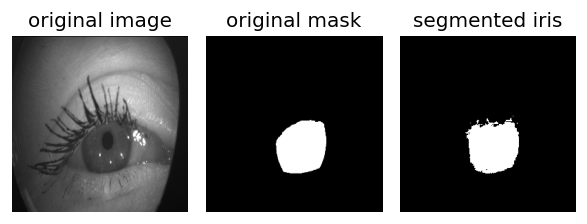

429/429 [==============================] - 53s 92ms/step - loss: 0.0193 - dice_coef: 0.9260 - jaccard: 0.8648 - val_loss: 0.1200 - val_dice_coef: 0.7626 - val_jaccard: 0.6214
Epoch 17/40
429/429 [==============================] - ETA: 0s - loss: 0.0182 - dice_coef: 0.9297 - jaccard: 0.8698

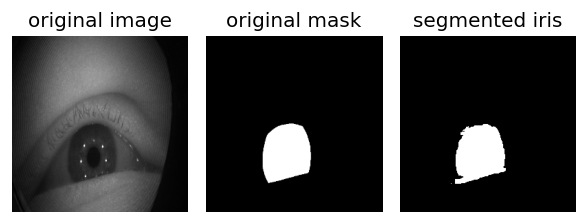

429/429 [==============================] - 53s 92ms/step - loss: 0.0182 - dice_coef: 0.9297 - jaccard: 0.8698 - val_loss: 0.0481 - val_dice_coef: 0.8842 - val_jaccard: 0.7951
Epoch 18/40
429/429 [==============================] - ETA: 0s - loss: 0.0144 - dice_coef: 0.9437 - jaccard: 0.8941

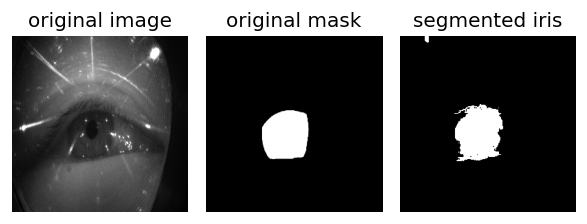

429/429 [==============================] - 53s 91ms/step - loss: 0.0144 - dice_coef: 0.9437 - jaccard: 0.8941 - val_loss: 0.0513 - val_dice_coef: 0.8888 - val_jaccard: 0.8023
Epoch 19/40
429/429 [==============================] - ETA: 0s - loss: 0.0139 - dice_coef: 0.9461 - jaccard: 0.8982

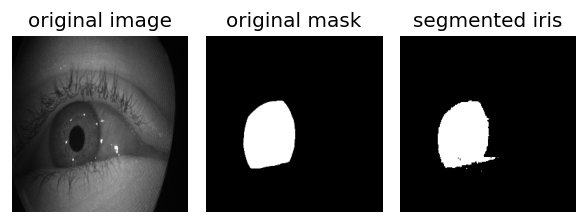

429/429 [==============================] - 59s 91ms/step - loss: 0.0139 - dice_coef: 0.9461 - jaccard: 0.8982 - val_loss: 0.0453 - val_dice_coef: 0.8949 - val_jaccard: 0.8120
Epoch 20/40
429/429 [==============================] - ETA: 0s - loss: 0.0129 - dice_coef: 0.9496 - jaccard: 0.9045

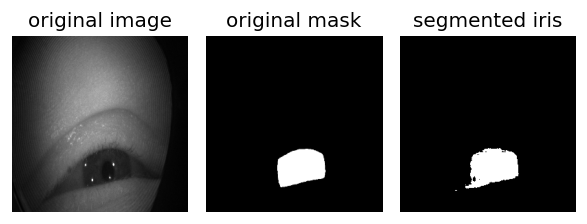

429/429 [==============================] - 52s 92ms/step - loss: 0.0129 - dice_coef: 0.9496 - jaccard: 0.9045 - val_loss: 0.0506 - val_dice_coef: 0.8947 - val_jaccard: 0.8118
Epoch 21/40
429/429 [==============================] - ETA: 0s - loss: 0.0126 - dice_coef: 0.9509 - jaccard: 0.9069

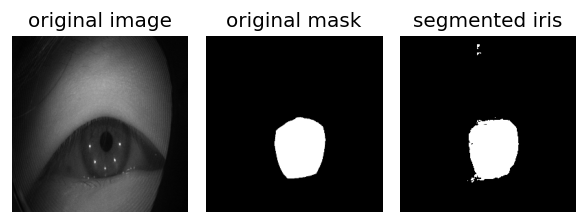

429/429 [==============================] - 53s 91ms/step - loss: 0.0126 - dice_coef: 0.9509 - jaccard: 0.9069 - val_loss: 0.0396 - val_dice_coef: 0.9104 - val_jaccard: 0.8378
Epoch 22/40
429/429 [==============================] - ETA: 0s - loss: 0.0116 - dice_coef: 0.9545 - jaccard: 0.9133

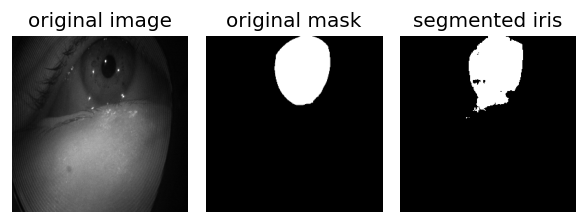

429/429 [==============================] - 59s 93ms/step - loss: 0.0116 - dice_coef: 0.9545 - jaccard: 0.9133 - val_loss: 0.0320 - val_dice_coef: 0.9209 - val_jaccard: 0.8549
Epoch 23/40
429/429 [==============================] - ETA: 0s - loss: 0.0151 - dice_coef: 0.9420 - jaccard: 0.8918

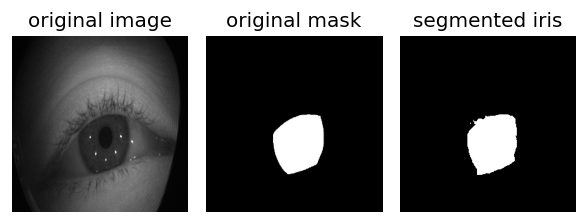

429/429 [==============================] - 59s 92ms/step - loss: 0.0151 - dice_coef: 0.9420 - jaccard: 0.8918 - val_loss: 0.0453 - val_dice_coef: 0.9029 - val_jaccard: 0.8249
Epoch 24/40
429/429 [==============================] - ETA: 0s - loss: 0.0102 - dice_coef: 0.9597 - jaccard: 0.9228

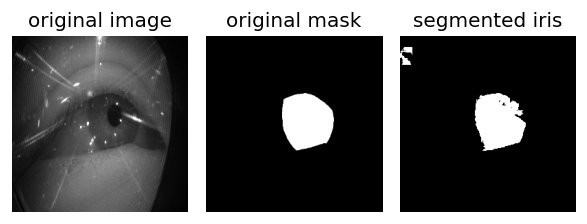

429/429 [==============================] - 60s 93ms/step - loss: 0.0102 - dice_coef: 0.9597 - jaccard: 0.9228 - val_loss: 0.0391 - val_dice_coef: 0.9157 - val_jaccard: 0.8462
Epoch 25/40
429/429 [==============================] - ETA: 0s - loss: 0.0106 - dice_coef: 0.9584 - jaccard: 0.9205

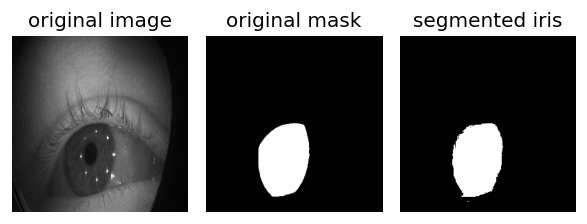

429/429 [==============================] - 55s 92ms/step - loss: 0.0106 - dice_coef: 0.9584 - jaccard: 0.9205 - val_loss: 0.0279 - val_dice_coef: 0.9304 - val_jaccard: 0.8711
Epoch 26/40
429/429 [==============================] - ETA: 0s - loss: 0.0095 - dice_coef: 0.9626 - jaccard: 0.9281

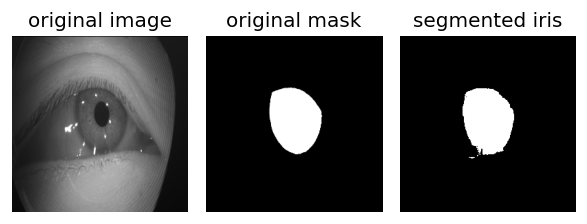

429/429 [==============================] - 53s 92ms/step - loss: 0.0095 - dice_coef: 0.9626 - jaccard: 0.9281 - val_loss: 0.0251 - val_dice_coef: 0.9363 - val_jaccard: 0.8813
Epoch 27/40
429/429 [==============================] - ETA: 0s - loss: 0.0111 - dice_coef: 0.9569 - jaccard: 0.9179

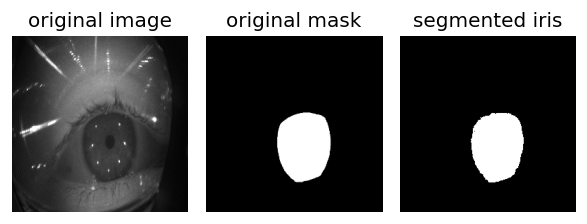

429/429 [==============================] - 53s 92ms/step - loss: 0.0111 - dice_coef: 0.9569 - jaccard: 0.9179 - val_loss: 0.0236 - val_dice_coef: 0.9350 - val_jaccard: 0.8789
Epoch 28/40
429/429 [==============================] - ETA: 0s - loss: 0.0094 - dice_coef: 0.9632 - jaccard: 0.9293

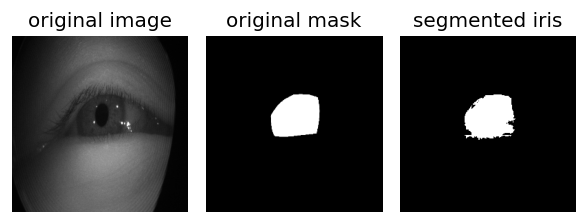

429/429 [==============================] - 54s 93ms/step - loss: 0.0094 - dice_coef: 0.9632 - jaccard: 0.9293 - val_loss: 0.0310 - val_dice_coef: 0.9159 - val_jaccard: 0.8461
Epoch 29/40
429/429 [==============================] - ETA: 0s - loss: 0.0092 - dice_coef: 0.9635 - jaccard: 0.9299

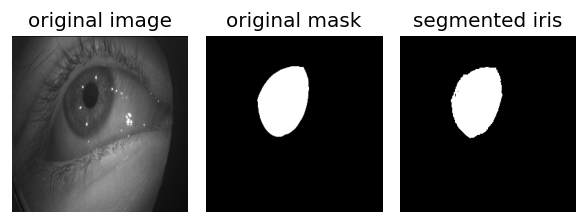

429/429 [==============================] - 52s 92ms/step - loss: 0.0092 - dice_coef: 0.9635 - jaccard: 0.9299 - val_loss: 0.0277 - val_dice_coef: 0.9340 - val_jaccard: 0.8772
Epoch 30/40
429/429 [==============================] - ETA: 0s - loss: 0.0094 - dice_coef: 0.9629 - jaccard: 0.9288

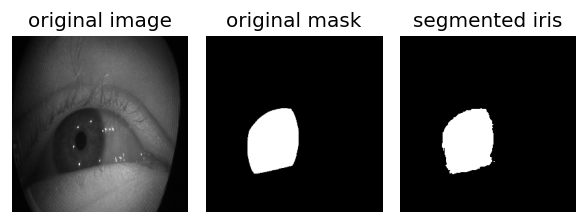

429/429 [==============================] - 54s 92ms/step - loss: 0.0094 - dice_coef: 0.9629 - jaccard: 0.9288 - val_loss: 0.0377 - val_dice_coef: 0.9156 - val_jaccard: 0.8457
Epoch 31/40
429/429 [==============================] - ETA: 0s - loss: 0.0085 - dice_coef: 0.9664 - jaccard: 0.9351

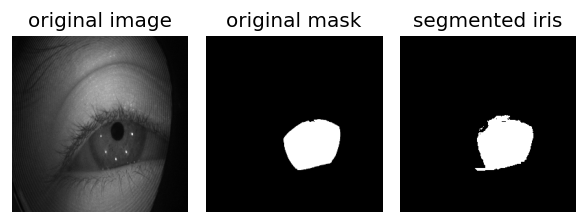

429/429 [==============================] - 52s 92ms/step - loss: 0.0085 - dice_coef: 0.9664 - jaccard: 0.9351 - val_loss: 0.0171 - val_dice_coef: 0.9478 - val_jaccard: 0.9014
Epoch 32/40
429/429 [==============================] - ETA: 0s - loss: 0.0081 - dice_coef: 0.9679 - jaccard: 0.9380

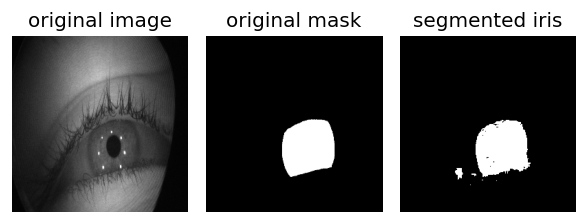

429/429 [==============================] - 52s 91ms/step - loss: 0.0081 - dice_coef: 0.9679 - jaccard: 0.9380 - val_loss: 0.0247 - val_dice_coef: 0.9409 - val_jaccard: 0.8893
Epoch 33/40
429/429 [==============================] - ETA: 0s - loss: 0.0110 - dice_coef: 0.9579 - jaccard: 0.9198

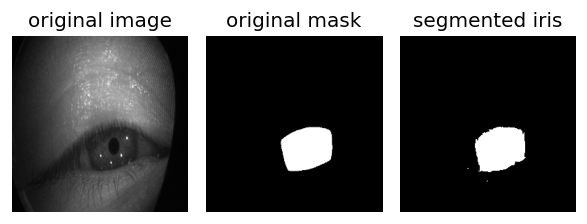

429/429 [==============================] - 54s 93ms/step - loss: 0.0110 - dice_coef: 0.9579 - jaccard: 0.9198 - val_loss: 0.0220 - val_dice_coef: 0.9431 - val_jaccard: 0.8930
Epoch 34/40
429/429 [==============================] - ETA: 0s - loss: 0.0077 - dice_coef: 0.9692 - jaccard: 0.9403

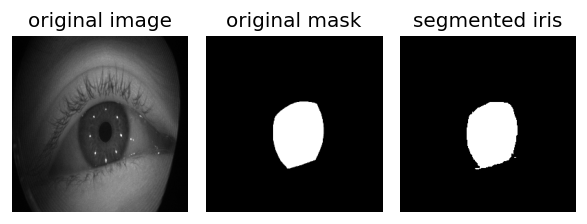

429/429 [==============================] - 53s 92ms/step - loss: 0.0077 - dice_coef: 0.9692 - jaccard: 0.9403 - val_loss: 0.0276 - val_dice_coef: 0.9363 - val_jaccard: 0.8812
Epoch 35/40
429/429 [==============================] - ETA: 0s - loss: 0.0074 - dice_coef: 0.9704 - jaccard: 0.9427

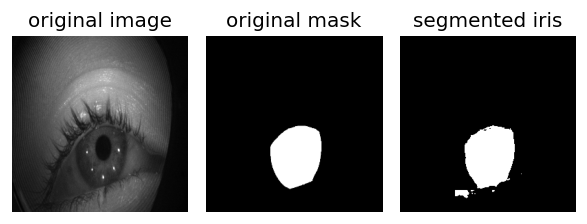

429/429 [==============================] - 54s 92ms/step - loss: 0.0074 - dice_coef: 0.9704 - jaccard: 0.9427 - val_loss: 0.0221 - val_dice_coef: 0.9473 - val_jaccard: 0.9007
Epoch 36/40
429/429 [==============================] - ETA: 0s - loss: 0.0075 - dice_coef: 0.9702 - jaccard: 0.9423

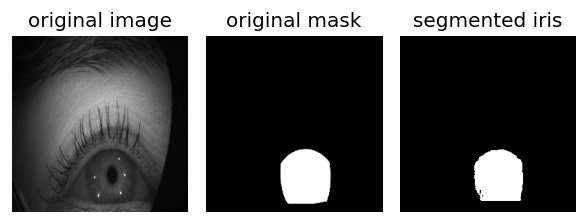

429/429 [==============================] - 54s 91ms/step - loss: 0.0075 - dice_coef: 0.9702 - jaccard: 0.9423 - val_loss: 0.0191 - val_dice_coef: 0.9491 - val_jaccard: 0.9039
Epoch 37/40
429/429 [==============================] - ETA: 0s - loss: 0.0078 - dice_coef: 0.9691 - jaccard: 0.9403

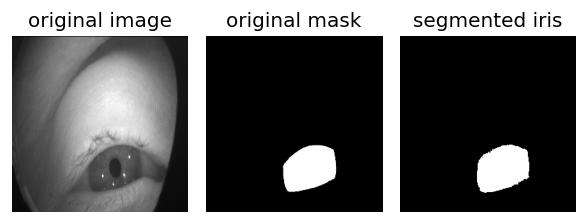

429/429 [==============================] - 54s 92ms/step - loss: 0.0078 - dice_coef: 0.9691 - jaccard: 0.9403 - val_loss: 0.0207 - val_dice_coef: 0.9464 - val_jaccard: 0.8989
Epoch 38/40
429/429 [==============================] - ETA: 0s - loss: 0.0075 - dice_coef: 0.9704 - jaccard: 0.9426

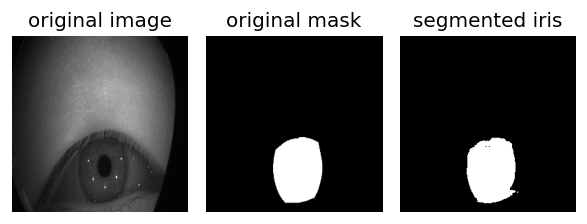

429/429 [==============================] - 52s 92ms/step - loss: 0.0075 - dice_coef: 0.9704 - jaccard: 0.9426 - val_loss: 0.0141 - val_dice_coef: 0.9582 - val_jaccard: 0.9201
Epoch 39/40
429/429 [==============================] - ETA: 0s - loss: 0.0071 - dice_coef: 0.9717 - jaccard: 0.9452

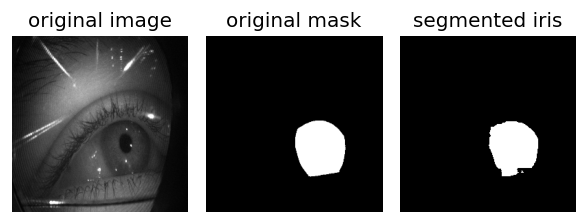

429/429 [==============================] - 53s 91ms/step - loss: 0.0071 - dice_coef: 0.9717 - jaccard: 0.9452 - val_loss: 0.0168 - val_dice_coef: 0.9521 - val_jaccard: 0.9092
Epoch 40/40
429/429 [==============================] - ETA: 0s - loss: 0.0073 - dice_coef: 0.9710 - jaccard: 0.9437

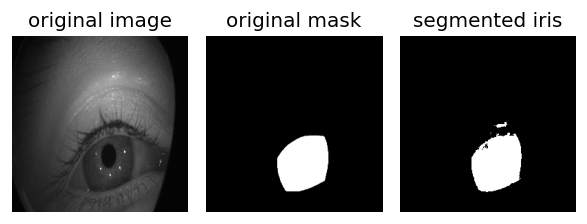

429/429 [==============================] - 54s 92ms/step - loss: 0.0073 - dice_coef: 0.9710 - jaccard: 0.9437 - val_loss: 0.0238 - val_dice_coef: 0.9400 - val_jaccard: 0.8876


In [17]:
hist = model.fit(train_dataset, validation_data = val_dataset, batch_size= BATCH_SIZE, epochs = 40, callbacks = my_callbacks)

# <span style="color:#e74c3c;"> Training </span> Results


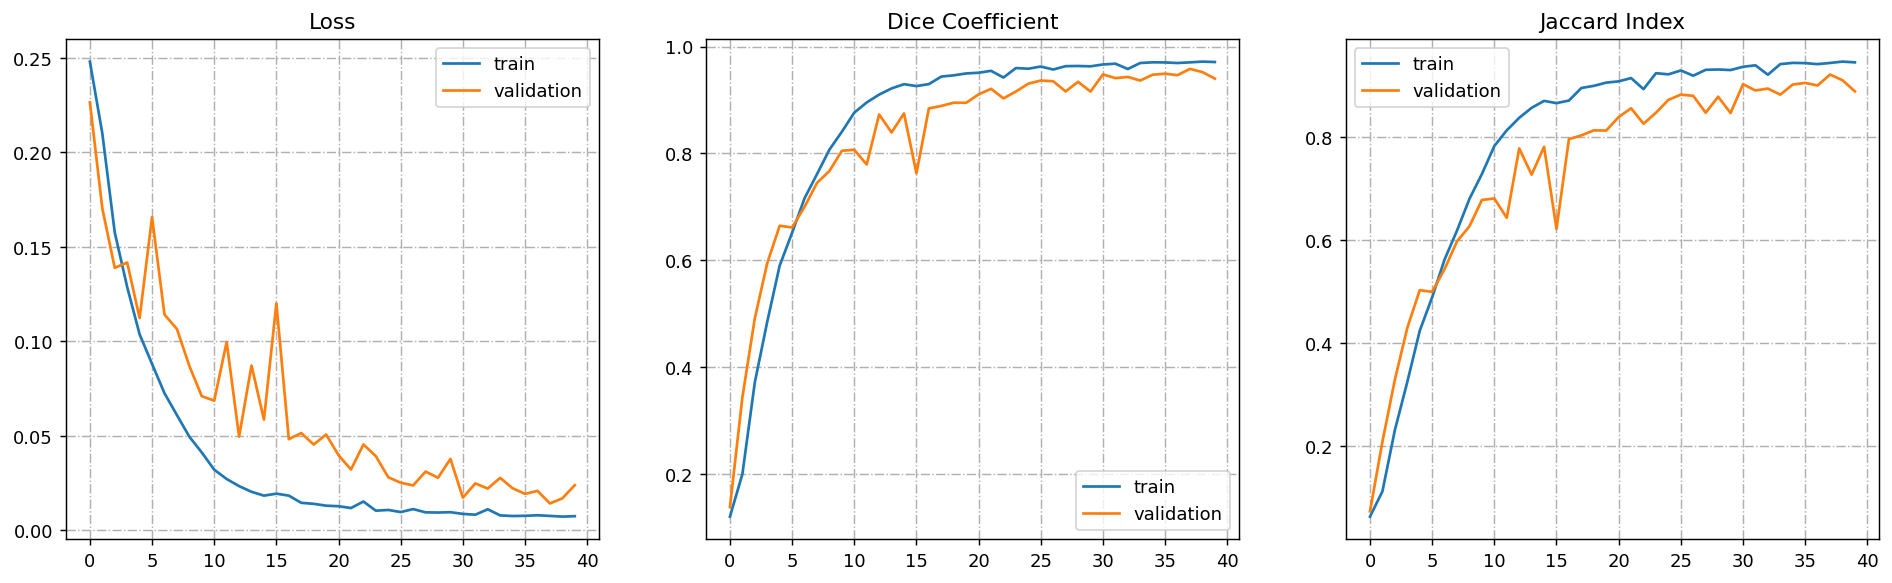

In [18]:
fig, axs = plt.subplots(1,3, figsize = (18,5), dpi = 130)

axs[0].grid(linestyle="dashdot")
axs[0].set_title("Loss")
axs[0].plot(hist.history['loss'])
axs[0].plot(hist.history['val_loss'])
axs[0].legend(["train", "validation"])

axs[1].grid(linestyle="dashdot")
axs[1].set_title("Dice Coefficient")
axs[1].plot(hist.history['dice_coef'])
axs[1].plot(hist.history['val_dice_coef'])
axs[1].legend(["train", "validation"])

axs[2].grid(linestyle="dashdot")
axs[2].set_title("Jaccard Index")
axs[2].plot(hist.history['jaccard'])
axs[2].plot(hist.history['val_jaccard'])
axs[2].legend(["train", "validation"])

# <span style="color:#e74c3c;"> Test </span> Prediction, Evaluation


In [19]:
test_eval = model.evaluate(test_dataset)

43/43 [==============================] - 4s 53ms/step - loss: 0.0238 - dice_coef: 0.9400 - jaccard: 0.8876


In [20]:
test_take1 =  test_dataset.take(-1)
test_take1_ = list(test_take1)
pred = model.predict(test_take1)

y_test_take = []
for x in range(len(test_take1_)):
    y_test_take.extend(test_take1_[x][1].numpy())
    
pred_ = np.squeeze(pred)
threshold  = 0.97 #threshold for prediction
bitmap_pred = (pred_ > threshold).astype(np.uint8)

2023-09-09 17:59:56.252220: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-09-09 17:59:56.366470: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


43/43 [==============================] - 21s 268ms/step


In [21]:
# A function that creating one random image in the test set and prediction it

def random_test_sample_with_prediction():
    idxs = np.random.permutation(len(y_test_take))[0]
    batch_idx = idxs // BATCH_SIZE
    image_idx = idxs-batch_idx * BATCH_SIZE
    idx = idxs

    image = test_take1_[batch_idx][0][image_idx]
    mask = test_take1_[batch_idx][1][image_idx]
    pred_mask = bitmap_pred[idx]
    segmented = np.squeeze(test_take1_[batch_idx][0][image_idx] ) * pred_mask

    fig, axs = plt.subplots(1,4, figsize = (8,4) ,dpi = 200)

    axs[0].imshow(image , cmap = 'gray')
    axs[0].axis('off')
    axs[0].set_title('original image (no: ' + str(idxs) + ")", fontsize = 8)

    axs[1].imshow(mask, cmap = 'gray')
    axs[1].axis('off')
    axs[1].set_title('original mask', fontsize = 8)

    axs[2].imshow(pred_mask , cmap = 'gray')
    axs[2].axis('off')
    axs[2].set_title('pred mask', fontsize = 8)

    axs[3].imshow(image , cmap ='gray')
    axs[3].imshow(segmented , alpha=0.65, cmap = 'cool')
    axs[3].axis('off')
    axs[3].set_title('segmentated iris', fontsize = 8)

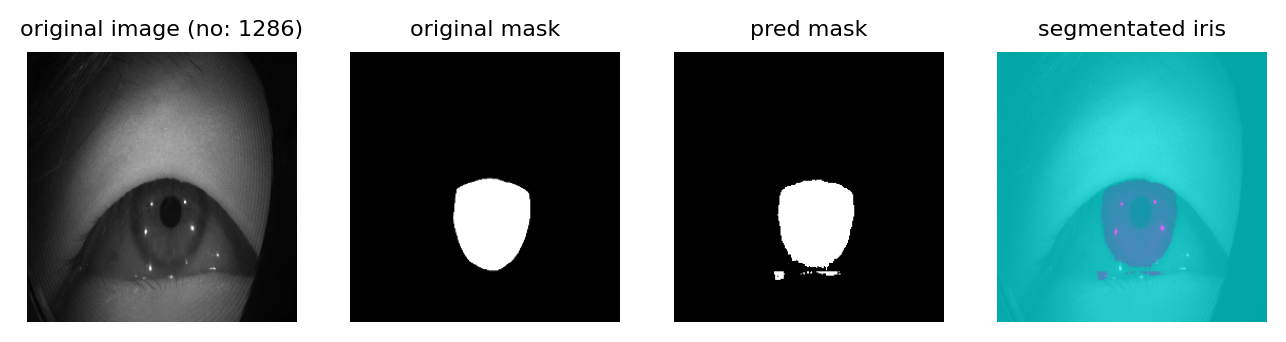

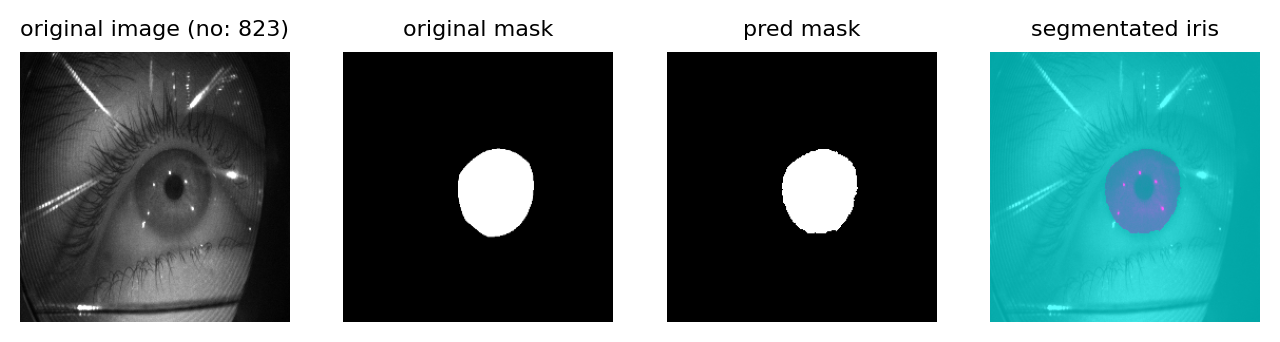

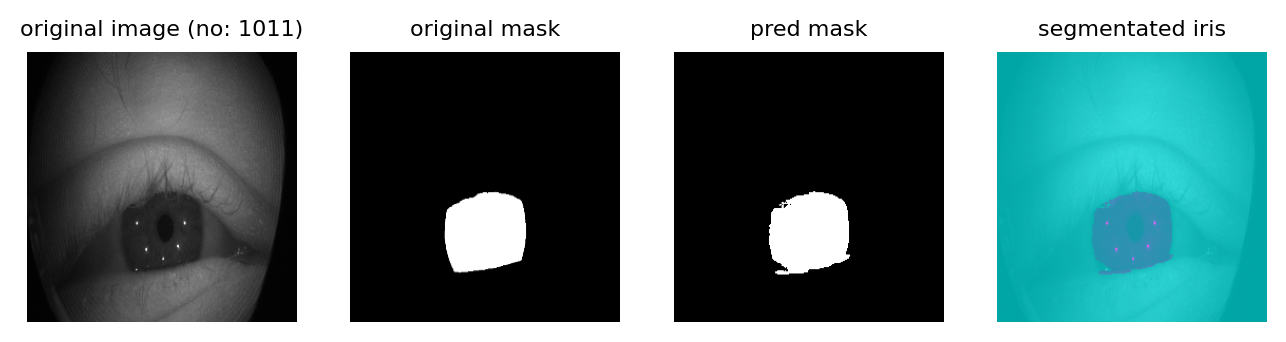

In [22]:
random_test_sample_with_prediction()
random_test_sample_with_prediction()
random_test_sample_with_prediction()